In [1]:
import dataprocess as dp
import transformers
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

#TODO Normalize Xtest
#Make our own loss function

# Hyperparameters
# Batch Size, Num Epochs, Learning Rate, Momentum, FC Layer, Activation Function


# 0 Lowercase & N2W
# 1 Contractions
# 2 Remove Punctutations
# 3 Strop Words

num_training = 500000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(net, input_id, labels):
    j = len(labels)

    guesses = net(input_id)
    print("GUESS_A: ", guesses)

    guesses = torch.argsort(net(input_id), dim=1, descending=True)
    print("GUESS_B: ", guesses)

    # guess1 = torch.argmax(guesses, dim=1)
    # guess2 = torch.argsort(guesses, dim=1)[-2]


    # current_real = torch.tensor(labels)
    current_real = labels.clone().detach()

    top1_acc = torch.sum(current_real==guesses[:,0])
    top2_acc = torch.sum(current_real==guesses[:,1])


    # print(guesses[:100])
    # print(current_real[:100])
    # print("Guess: ", guesses, "Label: ", current_real)

    accuracy_1 = top1_acc / j
    accuracy_2 = (top2_acc + top1_acc) / j
    # print(running_acc)
    # print(j)

    print('Accuracy for top 1: %d %%' % ((accuracy_1) * 100.0))
    print('Accuracy for top 2: %d %%' % ((accuracy_2) * 100.0))

    return accuracy_1, accuracy_2

    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aymane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Aymane\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aymane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
# !cd GitHub/EC523_Project/
# !pip install transformers

In [60]:
path = r"C:\Users\Aymane\GitHub\EC523_Project\data\Electronics\BERT Tokenized\reviews_Electronics_5_15_tokenized.pickle"
data = dp.unpickle_data(path)

In [61]:
input_ids = data["reviewText"]["input_ids"][:num_training]
attention_mask = data["reviewText"]["attention_mask"][:num_training]

In [ ]:
data["reviewText"] = dp.encode_data_BERT(input_ids, attention_mask, batch_size=5)

dp.pickle_data(data, "test_data_aymane_5_15.pickle")

In [2]:
data = dp.unpickle_data(r"reviews_Electronics_5_7_encoded.pickle")

In [3]:
sentences = data['reviewText'][:num_training]
labels = data['overall'][:num_training]
print(sentences.shape)
print(len(labels))

torch.Size([500000, 768])
500000


In [4]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.1, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

X_test = torch.tensor(X_test).cuda()
y_test = torch.tensor(y_test).cuda()

for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1 

print(y_test)

# indecies = torch.permute(indecies)
# X_train = X_train[indexes,:]

X_train = X_train.clone().detach()
y_train = torch.tensor(y_train)

C:\Users\Aymane\AppData\Local\Temp\ipykernel_13924\2229738559.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).cuda()


tensor([2., 4., 4.,  ..., 1., 3., 4.], device='cuda:0')


In [5]:
rev1 = X_train[y_train==1]
rev2 = X_train[y_train==2]
rev3 = X_train[y_train==3]
rev4 = X_train[y_train==4]
rev5 = X_train[y_train==5]

training_points = min(len(rev1), len(rev2), len(rev3), len(rev4), len(rev5))

rev1 = rev1 [:training_points]
rev2 = rev2 [:training_points]
rev3 = rev3 [:training_points]
rev4 = rev4 [:training_points]
rev5 = rev5 [:training_points]

indicies = torch.randperm(training_points * 5)

X_train = torch.cat((rev1, rev2, rev3, rev4, rev5), dim=0)[indicies, :]
base = torch.zeros(training_points)
y_train = torch.cat((base,base+1,base+2,base+3,base+4))[indicies]


In [6]:
class Net(nn.Module):
    def __init__(self, output_dim=5, dropout=0.5):
        # self.loss = torch.nn.MSELoss()
        super(Net, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 300)
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, output_dim)

    #def forward(self, input_id, mask):
    def forward(self, X_train):
        x = self.dropout(X_train)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [7]:
# criterion = torch.nn.MSELoss().to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
NUM_EPOCH = 2000
LR_START  = 1e-1
LR_END    = 1e-4
LR_GAMMA  = (LR_END/LR_START)**(1/NUM_EPOCH)

net = Net(output_dim=5,dropout=0).to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=LR_START, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = ExponentialLR(optimizer, gamma=LR_GAMMA)

In [8]:
X_train = X_train.to(device)
y_train = y_train.long().to(device)

$$
\gamma = \left( \frac{\alpha}{\beta} \right)^{\frac{1}{e}}
$$

gamma is decay rate

beta is start learning rate

alpha is ending learning rate

e is number of epochs

[1,     1] loss: 1.495
[1,   101] loss: 1.468
[1,   201] loss: 1.502
[1,   301] loss: 1.454
[1,   401] loss: 1.499
[1,   501] loss: 1.463
[2,     1] loss: 1.516
[2,   101] loss: 1.469
[2,   201] loss: 1.502
[2,   301] loss: 1.453
[2,   401] loss: 1.499
[2,   501] loss: 1.463
[3,     1] loss: 1.516
[3,   101] loss: 1.469
[3,   201] loss: 1.502
[3,   301] loss: 1.453
[3,   401] loss: 1.499
[3,   501] loss: 1.463
[4,     1] loss: 1.515
[4,   101] loss: 1.469
[4,   201] loss: 1.502
[4,   301] loss: 1.452
[4,   401] loss: 1.499
[4,   501] loss: 1.463
[5,     1] loss: 1.515
[5,   101] loss: 1.469
[5,   201] loss: 1.502
[5,   301] loss: 1.452
[5,   401] loss: 1.499
[5,   501] loss: 1.463
[6,     1] loss: 1.515
[6,   101] loss: 1.469
[6,   201] loss: 1.502
[6,   301] loss: 1.452
[6,   401] loss: 1.499
[6,   501] loss: 1.463
[7,     1] loss: 1.515
[7,   101] loss: 1.469
[7,   201] loss: 1.502
[7,   301] loss: 1.452
[7,   401] loss: 1.499
[7,   501] loss: 1.464
[8,     1] loss: 1.515
[8,   101] 

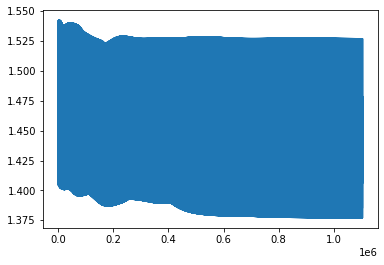

In [10]:
batch_size = 200
indecies = torch.tensor(range(batch_size))

losses = []
for epoch in range(NUM_EPOCH):
    running_loss = 0.0
    for i in range(len(y_train)//batch_size):
    #for i in range(1):
        select = batch_size * i + indecies
        optimizer.zero_grad()
        outputs = net(X_train[select,:])

        loss = criterion(outputs, y_train[select])
        
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss ))
        
        losses.append(running_loss)
        running_loss = 0.0

    scheduler.step()
  

print('Finished Training')
plt.plot(losses)


In [12]:
# net = net.eval()

train_acc = accuracy(net, X_train.cuda(), y_train.cuda())
test_acc = accuracy(net, X_test, y_test)

GUESS_A:  tensor([[1.8645e-07, 2.6445e-04, 2.1688e-03, 5.0240e-02, 9.4733e-01],
        [3.2992e-07, 1.2445e-02, 1.6524e-01, 8.1941e-01, 2.9030e-03],
        [1.3870e-01, 8.2127e-01, 3.9988e-02, 3.3751e-05, 7.8831e-08],
        ...,
        [3.9649e-01, 4.8372e-01, 6.2158e-02, 2.0697e-02, 3.6938e-02],
        [7.2172e-01, 2.7645e-01, 1.8108e-03, 9.8237e-06, 1.4335e-07],
        [5.0428e-07, 1.0395e-02, 4.0641e-01, 5.8186e-01, 1.3348e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
GUESS_B:  tensor([[4, 3, 2, 1, 0],
        [3, 2, 1, 4, 0],
        [1, 0, 2, 3, 4],
        ...,
        [1, 0, 2, 4, 3],
        [0, 1, 2, 3, 4],
        [3, 2, 1, 4, 0]], device='cuda:0')
Accuracy for top 1: 43 %
Accuracy for top 2: 69 %
GUESS_A:  tensor([[4.8852e-01, 4.7930e-01, 3.1821e-02, 3.0375e-04, 6.1921e-05],
        [2.7864e-06, 2.0047e-03, 4.8211e-02, 3.5617e-01, 5.9361e-01],
        [3.2959e-10, 3.2141e-09, 6.5897e-08, 3.7980e-04, 9.9962e-01],
        ...,
        [6.5594e-01, 3.2145e-01